In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as signal
from scipy.interpolate import interp1d
import neurokit2 as nk


In [102]:
def conv(signal, kernel):
    signal_length = len(signal)
    kernel_length = len(kernel)
    output_length = signal_length - kernel_length + 1
    result = np.zeros(output_length)

    for i in range(output_length):
        signal_slice = signal[i:i + kernel_length]
        norm_signal_slice = signal_slice / np.linalg.norm(signal_slice)
        norm_kernel = kernel / np.linalg.norm(signal_slice)
        
        result[i] = np.dot(norm_signal_slice, norm_kernel)
        
    return result

In [103]:
def amplitude_in_band(conv_res, min_fr, max_fr):
    frequencies, _, Zxx = signal.stft(
        conv_res,
        fs=64,
        window='hann',
        nperseg=256,
        noverlap=250
    )

    freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)

    amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

    return amplitude_in_band


In [104]:
def create_mask(min_amplitude, max_amplitude, min_len_interval, amplitude_in_band, len_ppg):
    # Создаем базовую маску валидных значений
    valid = (amplitude_in_band >= min_amplitude) & (amplitude_in_band <= max_amplitude)
    
    # Находим границы интервалов
    diff = np.diff(valid.astype(int))
    starts = np.where(diff == 1)[0] + 1
    ends = np.where(diff == -1)[0] + 1

    # Корректируем границы для начала/конца сигнала
    if valid[0]:
        starts = np.insert(starts, 0, 0)
    if valid[-1]:
        ends = np.append(ends, len(valid))
    
    # Формируем интервалы и фильтруем по длине
    intervals = []
    for s, e in zip(starts, ends):
        if e - s >= min_len_interval:
            intervals.append((s, e))
    
    # Создаем итоговую маску
    time_mask = np.zeros_like(valid, dtype=bool)
    for s, e in intervals:
        time_mask[s:e] = True

    # Интерполяция для PPG сигнала
    indices_mask = np.arange(len(time_mask))
    indices_ppg = np.linspace(0, len(time_mask)-1, len_ppg)
    
    mask_func = interp1d(
        indices_mask,
        time_mask,
        kind='nearest',
        bounds_error=False,
        fill_value=False
    )
    
    return mask_func(indices_ppg).astype(bool)

In [105]:
def drow_data(ppg, ylim, person_name, status):
    if len(ppg) > 0:
        wigth = len(ppg) // 256
        figr = plt.figure(figsize=(wigth, 6))
        plt.plot(ppg)
        plt.grid(True)  
        # plt.ylim(ylim[0], ylim[1])
        plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/{person_name}_{status}.png', dpi=300, bbox_inches='tight')
        plt.close(figr)


In [106]:
def filt_data(ppg, path_to_ref_signal, min_fr, max_rf, min_amp, max_amp, min_interval_len):
    reference_wave = np.load(path_to_ref_signal)
    conv_res = conv(ppg, reference_wave)
    res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
    mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))
    filt_ppg = ppg[mask]

    return filt_ppg

In [107]:
def bandpass_filter(data, lowcut, highcut, fs, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = signal.butter(order, [low, high], btype='band')
    return signal.filtfilt(b, a, data)

In [108]:
def adaptive_normalization(signal, window_size=256):
    normalized = np.zeros_like(signal)

    for i in range(len(signal)):
        start = max(0, i - window_size // 2)
        end = min(len(signal), i + window_size // 2)

        local_mean = np.mean(signal[start:end])
        local_std = np.std(signal[start:end])

        normalized[i] = (signal[i] - local_mean) / local_std
    return normalized

код для загрузки чистого сигнала, в дальнейшем будет ядром свертки

In [109]:
# взятие чистого сигнала

# ppg_filt = bandpass_filter(ppg, 1, 3, ppg_sr)
# ppg_adaptive = adaptive_normalization(ppg_filt, 512)
# drow_data(ppg_adaptive, (-4, 4), "ppg", "md")

# np.save('/home/ilya/Documents/stress-level-by-PPG/working with braslet/ppg.npy', ppg_)
# drow_data(ppg_, (-4, 4), "Ilia_adaptive", "md")

# sec_with = 46
# count_sec = 1

# reference_wave = ppg_adaptive[ppg_sr * sec_with + 40: ppg_sr * (count_sec + sec_with) - 40]
# np.save('/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/reference_wave.npy', reference_wave)

# plt.figure(figsize=(5, 4))
# plt.plot(reference_wave)
# plt.title("Чистый сигнал")
# plt.ylim(-4, 4)
# plt.grid(True)

In [110]:
def filtering(ppg, reference_wave, ppg_fr=256, min_fr=1, max_rf=2, min_amp=0, max_amp=0.035, min_interval_len=512):
    ppg = bandpass_filter(ppg, 0.25, 3, ppg_fr)
    ppg = adaptive_normalization(ppg, 512)
    conv_res = conv(ppg, reference_wave)
    
    res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
    mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))

    ppg[~mask] = 0
    return ppg.copy()


отладочный код, отображение каждого этапа фильтрации

загружаем сигнал

In [111]:
reference_wave = np.load('/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/reference_wave.npy')

path = '/home/ilya/Documents/stress-level-by-PPG/dataframe/test_movie_2.csv'
data = pd.read_csv(path)
display(data.head())

sec_with = 0
count_sec = 350
ppg_fr = 256

ppg = data["afe_LED1ABSVAL"][ppg_fr * sec_with : ppg_fr * (count_sec + sec_with)].to_numpy(dtype='float32')
ppg.shape

,device_name,comment,package_number,time,eda,accel_X,accel_Y,accel_Z,afe_LED1ABSVAL,battery,temperature,package_num
0,test_movie_1,device,34,2025-03-30 15:01:32.587808,2304,65324,22,999,15764114,3751,0,166
1,test_movie_1,device,34,2025-03-30 15:01:32.588191,2304,65324,22,999,15764184,3751,0,166
2,test_movie_1,device,34,2025-03-30 15:01:32.588284,2304,65324,22,999,15764289,3737,0,166
3,test_movie_1,device,34,2025-03-30 15:01:32.588335,2304,65324,22,999,15764478,3737,0,166
4,test_movie_1,device,34,2025-03-30 15:01:32.588364,2304,65324,22,999,15763958,3737,0,166


(89600,)

фильтрация

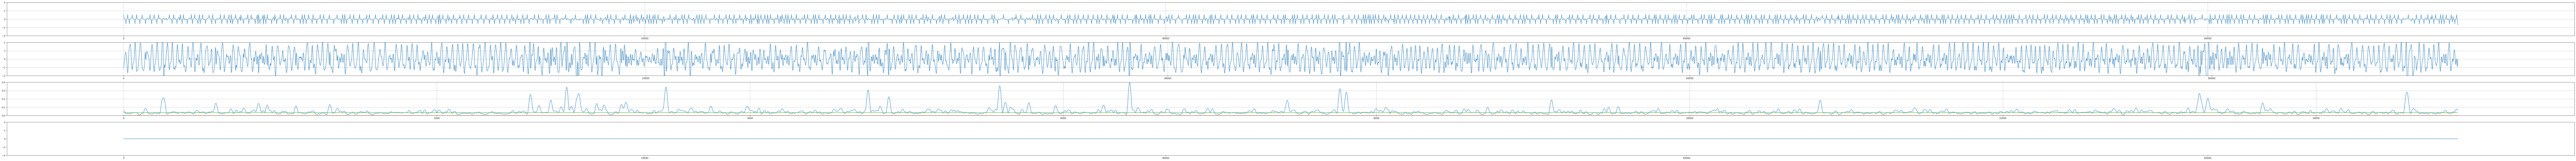

In [118]:
min_fr=1
max_rf=2
min_amp=0
max_amp=0.035
min_interval_len=512

ppg = bandpass_filter(ppg, 0.25, 3, ppg_fr)
ppg = adaptive_normalization(ppg, 32)
conv_res = conv(ppg, reference_wave)

res_amplitude = amplitude_in_band(conv_res, min_fr, max_rf)
mask = create_mask(min_amp, max_amp, min_interval_len, res_amplitude, len(ppg))

res_ppg = ppg.copy()
res_ppg[~mask] = 0 

plt.figure(figsize=(200, 12))

plt.subplot(4, 1, 1)
plt.plot(ppg)
plt.ylim(-4, 4)
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(conv_res)
plt.ylim(-2, 2)
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(res_amplitude)
plt.plot([min_amp] * len(res_amplitude))
plt.plot([max_amp] * len(res_amplitude))
plt.ylim(0, 0.4)
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(res_ppg)
plt.ylim(-4, 4)

plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/ppg-conv-ampl-mask.png', dpi=300, bbox_inches='tight')
plt.show()

In [113]:
filt_ppg = filtering(ppg, reference_wave)

drow_data(filt_ppg, (-4, 4), "ppg", "filt")

окном считаем признаки

In [114]:
feature = ['HRV_MeanNN', 'HRV_SDNN', 'HRV_RMSSD', 'HRV_SDSD', 'HRV_CVNN', 'HRV_CVSD', 'HRV_MedianNN', 'HRV_MadNN', 'HRV_pNN50', 'HRV_pNN20', 'HRV_MinNN', 'HRV_MaxNN', 'HRV_HTI', 'HRV_TINN', 'HRV_HF', 'stress_index']

In [115]:
def get_feature_nk(signal, label, ppg_fr):
    peaks, _ = nk.ppg_peaks(signal, sampling_rate=ppg_fr, show=False)
    custom_scales = [4, 8, 16]

    hrv_indixes = nk.hrv(
        peaks, 
        sampling_rate=ppg_fr,
        nonlinear_kwargs={"scale": custom_scales}
    )
    hrv_indixes['stress_index'] = label

    filt_hrv_indixes = hrv_indixes[feature]
    return filt_hrv_indixes.iloc[0].to_dict()

In [116]:
# frequencies, times, Zxx = signal.stft(
#     conv_res, 
#     fs=256, 
#     window='hann', 
#     nperseg=1024,
#     noverlap=1000
# )

# spectrogram = np.abs(Zxx)
# # print(frequencies)

# # Маска для целевой частоты
# min_fr = 0
# max_fr = 5
# freq_mask = (frequencies >= min_fr) & (frequencies <= max_fr)
# print(frequencies[freq_mask])

# # Амплитуда в целевой полосе
# amplitude_in_band = np.mean(np.abs(Zxx[freq_mask, :]), axis=0)

# wight = len(conv_res) / 256
# plt.figure(figsize=(wight, 7))

# plt.subplot(2, 1, 1)
# plt.pcolormesh(times, frequencies[freq_mask], spectrogram[freq_mask, : ], shading='gouraud', cmap='magma', vmin = 0, vmax=1)
# # plt.colorbar(label='Амплитуда (дБ)')
# plt.ylabel('Частота (Гц)')
# plt.title('Спектрограмма')

# plt.subplot(2, 1, 2)
# plt.plot(conv_res)
# plt.ylabel('Амплитуда')
# plt.title(f'PPG')
# plt.grid(True)
# plt.margins(x=0)
# plt.ylim(-4, 4)

# plt.savefig(f'/home/ilya/Documents/stress-level-by-PPG/working_with_braslet/spgrm_ppg_st.png', dpi=300, bbox_inches='tight')

# plt.show()

# plt.close()

In [117]:
# filt_ppg = ppg[mask]

# plt.figure(figsize=(50, 4))
# plt.plot(filt_ppg)
# plt.grid(True)
# plt.savefig(f'./res_filt_signal.png', dpi=300, bbox_inches='tight')